# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [2]:
dog_train_files = np.array(glob("/data/dog_images/train/*/*"))
dog_test_files = np.array(glob("/data/dog_images/test/*/*"))
dog_valid_files = np.array(glob("/data/dog_images/valid/*/*"))

print('There are %d total dog images in train dataset.' % len(dog_train_files))
print('There are %d total dog images in test dataset.' % len(dog_test_files))
print('There are %d total dog images in valid dataset.' % len(dog_valid_files))

There are 6680 total dog images in train dataset.
There are 836 total dog images in test dataset.
There are 835 total dog images in valid dataset.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


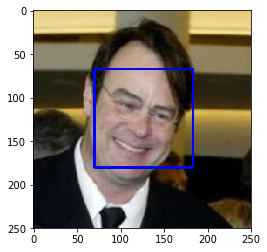

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
human_files

array(['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg',
       '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg',
       '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg', ...,
       '/data/lfw/Ferenc_Madl/Ferenc_Madl_0002.jpg',
       '/data/lfw/Jim_Flaherty/Jim_Flaherty_0001.jpg',
       '/data/lfw/Stacey_Yamaguchi/Stacey_Yamaguchi_0001.jpg'], 
      dtype='<U90')

In [5]:
dog_files

array(['/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg',
       '/data/dog_images/train/103.Mastiff/Mastiff_06826.jpg',
       '/data/dog_images/train/103.Mastiff/Mastiff_06871.jpg', ...,
       '/data/dog_images/valid/100.Lowchen/Lowchen_06682.jpg',
       '/data/dog_images/valid/100.Lowchen/Lowchen_06708.jpg',
       '/data/dog_images/valid/100.Lowchen/Lowchen_06684.jpg'], 
      dtype='<U106')

In [6]:
import os
dog_path = '/data/dog_images/train/'
class_names = os.listdir(dog_path)
class_dict = {}
dog_names = []
for counts, name in enumerate(class_names):
    class_dict[name] = len(os.listdir(os.path.join(dog_path, name)))
    dog_names.append(list(class_dict)[counts].split('.')[1].replace('_', ' ').title())

In [7]:
print('There are a minimum of %d dog images in train dataset.' % min(list(class_dict.values())))
print('There are a maximum of %d dog images in train dataset.' % max(list(class_dict.values())))

There are a minimum of 26 dog images in train dataset.
There are a maximum of 77 dog images in train dataset.


Text(0.5,1,'Distribution of Dog Breeds - Train Dataset')

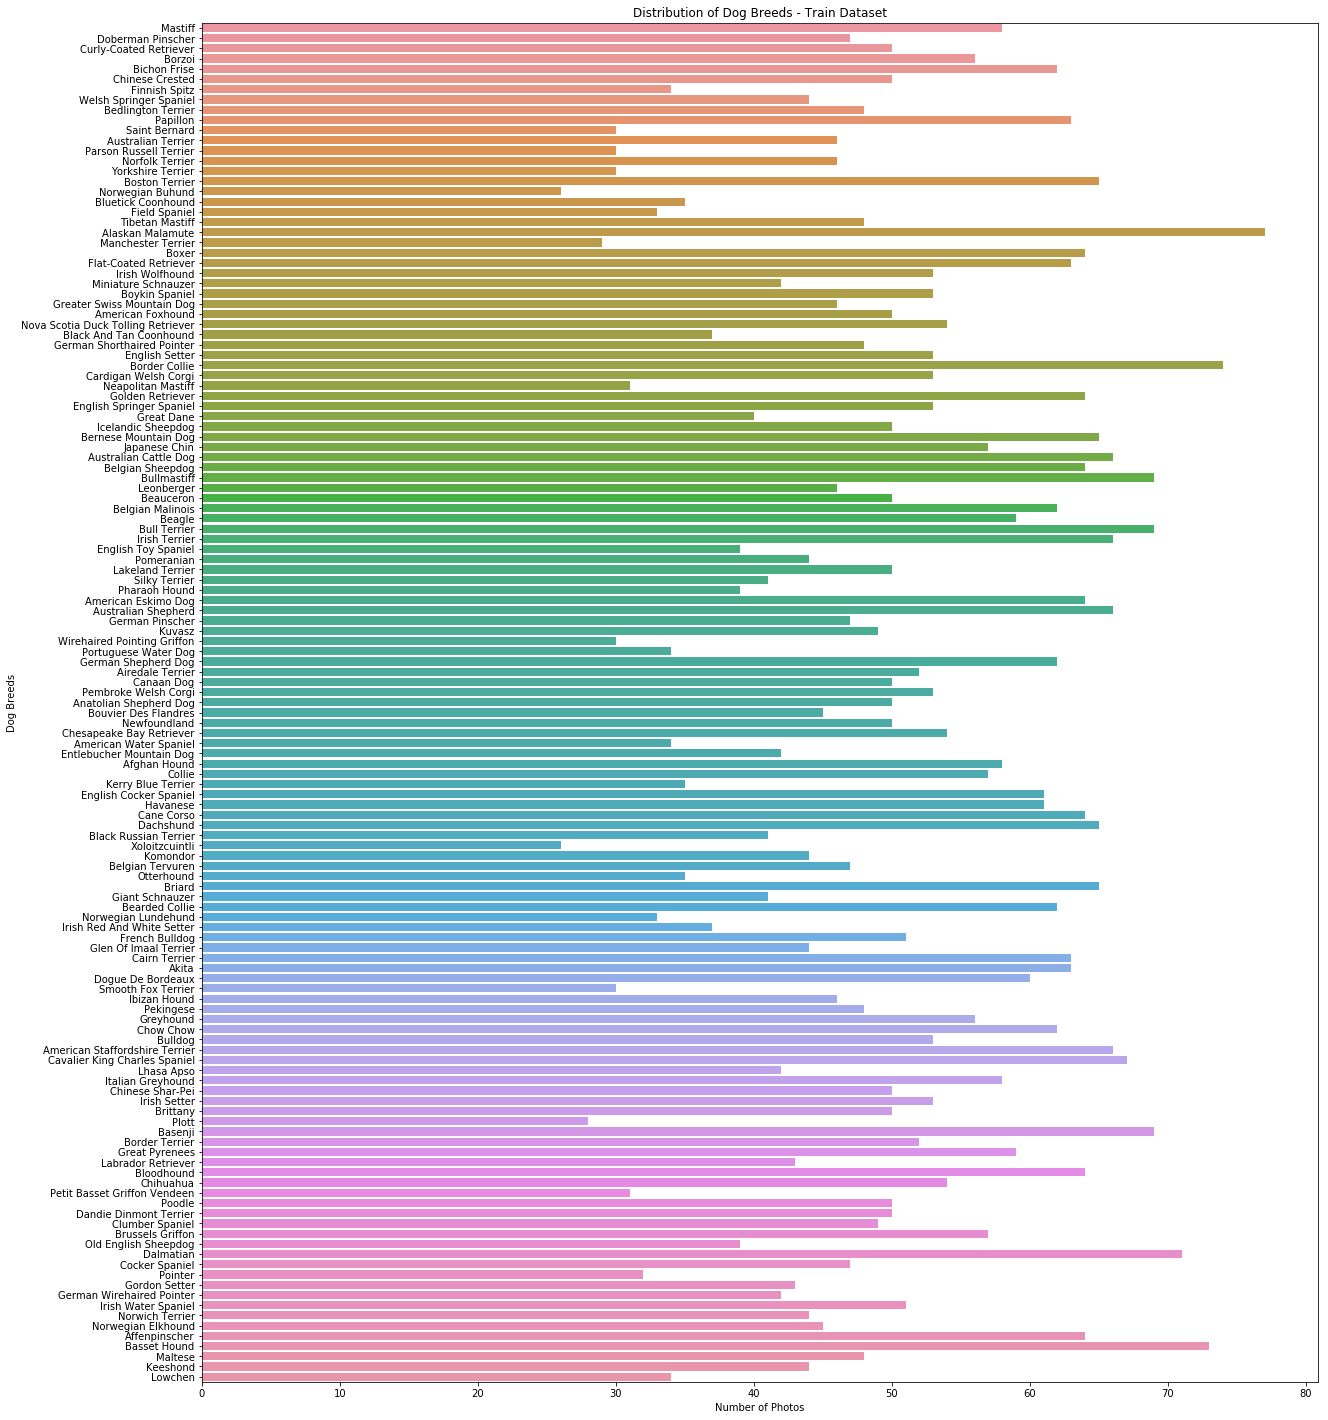

In [8]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(20,25)
ax = sns.barplot(x=list(class_dict.values()), y=dog_names)
plt.ylabel("Dog Breeds")
plt.xlabel("Number of Photos")
plt.title("Distribution of Dog Breeds - Train Dataset")

In [9]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
        '''
    Using pre-trained Haar feature-based cascade classifiers from OpenCV to identify if 
    a human face is present or not. This classifier uses 'haarcascades/haarcascade_frontalface_alt.xml'
    
    Args:
        img_path: path to an image
        
    Returns:
        True if a face was found. False if face no detected
    '''
    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [10]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_human_files = 0
human_dog_files = 0

for human in human_files_short:
    if face_detector(human):
        human_human_files += 1
for human in dog_files_short:
    if face_detector(human):
        human_dog_files += 1

print(f"The percentage of the first 100 images in human_files have detected human faces: {human_human_files}%")
print(f"The percentage of the first 100 images in dog_files have detected human faces: {human_dog_files}%")

The percentage of the first 100 images in human_files have detected human faces: 98%
The percentage of the first 100 images in dog_files have detected human faces: 17%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [11]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [12]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [13]:
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [14]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    image_transforms = transforms.Compose([transforms.Resize(255),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
    

    tensor_transforms = image_transforms(Image.open(img_path).convert('RGB'))[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        tensor_transforms = tensor_transforms.cuda()
    
    return torch.max((VGG16(tensor_transforms)), 1)[1].item() # predicted class index

In [15]:
VGG16_predict(dog_files_short[0])

243

In [16]:
# checking to make sure all good --> took this from Image Classifier Project from Term 1
def imshow(image, ax=None, title=None):
    '''  Imshow for Tensor
    
    Args:
        image: path to an image
        
    Returns:
        Image on a scale
    '''
 
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

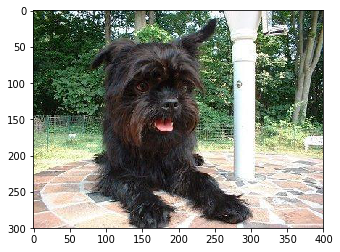

In [17]:
dog_img = Image.open('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')
plt.imshow(dog_img)
plt.show()

In [18]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model
        
        Args:
            image: path to an image
            
        Returns: an Numpy array
    '''
    
    image_transforms = transforms.Compose([transforms.Resize(255),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
    
    # TODO: Process a PIL image for use in a PyTorch model

    #py_image = image_transforms(Image.open(image).convert('RGB'))[:3,:,:]
    py_image = image_transforms(Image.open(image))
    return py_image

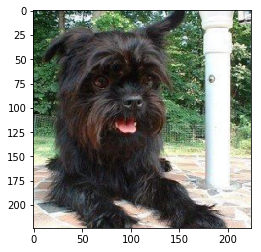

In [19]:
imshow(process_image('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg'))

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [20]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
            '''
    Using pre-trained VGG-16 model to predict if a dog is present in an image
    
    Args:
        img_path: path to an image
        
    Returns:
        True if a dog was found. False if dog is not detected
    '''
    
    ## TODO: Complete the function.
    predicted_idx = VGG16_predict(img_path)
    result = predicted_idx >=151 and predicted_idx <=268
    return result # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [21]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_human_files = 0
dog_dog_files = 0

for dog in human_files_short:
    if dog_detector(dog):
        dog_human_files += 1
for dog in dog_files_short:
    if dog_detector(dog):
        dog_dog_files += 1

print(f"The percentage of the first 100 images in human_files have detected dogs: {dog_human_files}%")
print(f"The percentage of the first 100 images in dog_files have detected dogs: {dog_dog_files}%")

The percentage of the first 100 images in human_files have detected dogs: 0%
The percentage of the first 100 images in dog_files have detected dogs: 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [22]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

    '''
    Use pre-trained ResNet50 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to ResNet50 model's prediction
    '''



# define ResNet50 model
ResNet50 = models.resnet50(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    ResNet50 = ResNet50.cuda()

def ResNet50_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    image_transforms = transforms.Compose([transforms.Resize(255),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
    ResNet50.eval()
    
    tensor_transforms = image_transforms(Image.open(img_path).convert('RGB'))[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        tensor_transforms = tensor_transforms.cuda()
    
    with torch.no_grad():
        pred = torch.argmax(ResNet50(tensor_transforms)).item()
        
    
    ResNet50.train()
    
    return pred # predicted class index

In [23]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_ResNet50(img_path):
                '''
    Using pre-trained ResNet-50 model to predict if a dog is present in an image
    
    Args:
        img_path: path to an image
        
    Returns:
        True if a dog was found. False if dog is not detected
    '''
    
    ## TODO: Complete the function.
    predicted_idx = ResNet50_predict(img_path)
    result = predicted_idx >=151 and predicted_idx <=268
    return result # true/false

dog_human_files_ResNet50 = 0
dog_dog_files_ResNet50 = 0

for dog in human_files_short:
    if dog_detector_ResNet50(dog):
        dog_human_files_ResNet50 += 1
for dog in dog_files_short:
    if dog_detector_ResNet50(dog):
        dog_dog_files_ResNet50 += 1

print(f"The percentage of the first 100 images in human_files have detected dogs: {dog_human_files_ResNet50}%")
print(f"The percentage of the first 100 images in dog_files have detected dogs: {dog_dog_files_ResNet50}%")

The percentage of the first 100 images in human_files have detected dogs: 0%
The percentage of the first 100 images in dog_files have detected dogs: 99%


In [24]:
ResNet50_predict(dog_files_short[0])

243

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [25]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = '/data/dog_images'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                                transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])]),
                  }

# TODO: Load the datasets with ImageFolder
image_datasets = {'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
                  'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
                  'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
                 }

# TODO: Using the image datasets and the trainforms, define the dataloaders
loaders_scratch = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
                   'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True),
                   'test' : torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=True)
                  }

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
My code resizes the images in the following ways:
- resize of 255 since this is how RGB images are normalized
- cropping size since input data is 224x224 pixels - required by the pre-trained network VGG16
- normalized with a mean [0.485, 0.456, 0.406] and standard deviations [0.229, 0.224, 0.225] since the colour channel was normalized separately, and therefore normalizing with the respective values is what the network expects

I decided to augment the dataset only on test dataset in the following ways:
- random rotation of 30
- random horizontal flip 

This is beneficial because it enhances the images by helping the network generalize allowing for better training observations and leading to better performance.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. Since this is the case, we don't want any scaling or rotation transformations, but we did need to resize then crop the images to the appropriate size.

In [26]:
dog_class = image_datasets['train'].classes
dog_class

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog',
 '011.Australian_cattle_dog',
 '012.Australian_shepherd',
 '013.Australian_terrier',
 '014.Basenji',
 '015.Basset_hound',
 '016.Beagle',
 '017.Bearded_collie',
 '018.Beauceron',
 '019.Bedlington_terrier',
 '020.Belgian_malinois',
 '021.Belgian_sheepdog',
 '022.Belgian_tervuren',
 '023.Bernese_mountain_dog',
 '024.Bichon_frise',
 '025.Black_and_tan_coonhound',
 '026.Black_russian_terrier',
 '027.Bloodhound',
 '028.Bluetick_coonhound',
 '029.Border_collie',
 '030.Border_terrier',
 '031.Borzoi',
 '032.Boston_terrier',
 '033.Bouvier_des_flandres',
 '034.Boxer',
 '035.Boykin_spaniel',
 '036.Briard',
 '037.Brittany',
 '038.Brussels_griffon',
 '039.Bull_terrier',
 '040.Bulldog',
 '041.Bullmastiff',
 '042.Cairn_terrier',
 '043.Canaan_do

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [27]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # pooling layer
        self.pool = nn.MaxPool2d(2,2)
        
        # linear layer
        self.fc1 = nn.Linear(128*14*14, 4096)
        self.fc2 = nn.Linear(4096, 133)
        
        # dropout layer
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        
        #flatten
        x = x.view(-1, 128*14*14)
        
        #hidden layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

The steps I took to get to my final CNN architecture are outlined below:
- Four convolution layers:
    - 16 filters
    - 32 filters
    - 64 filters
    - 128 filters
- Stride
    - 1 for all 4 convolution layers
- Max pooling that reduced the image size:
    - 112x112
    - 56x56
    - 28x28
    - 14x14
- Two linear layers:
    - (128 * 14 * 14)=25088 --> 4096
    - 4096 to the final output size of 133 for the number of classes of breeds
- Dropout to avoid overfitting:
    - set to 0.2
    

|    Layer            | Output Shape |
| :-----------:       | :---------------: |
| conv2d_1            |      224x224x16   |
| max_pooling2d       |      112x112x16   |
| -------------       |    -----------    |
| conv2d_2 (Conv2D)   |      112x112x32   |
| max_pooling2d       |      56x56x32     |
| -------------       |    -----------    |
| conv2d_3 (Conv2D)   |      56x56x64     |
| max_pooling2d       |      28x28x64     |
| -------------       |    -----------    |
| conv2d_4 (Conv2D)   |      28x28x128    |
| max_pooling2d       |      14x14x128    |


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [28]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.02)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [29]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [30]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """
    This function trains the model based on arguments
    
    Args:
        n_epochs:  # of epochs to train
        loaders:   dictionary of defined dataloaders
        model:     model being trained
        optimizer: optimizer
        criterion: loss function
        use_cuda:  if GPU used = True, if CPU used = False
        save_path: path to save the model to
    
    Returns:
        trained model, train and validation loss
    """
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target) ## evaluate loss
            loss.backward() ## back propagation
            optimizer.step()
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Saving model. Validation loss has decreased from {:.6f} to {:.6f}'.format(
            valid_loss_min,
            valid_loss))
            
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
model_scratch = train(75, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.883615 	Validation Loss: 4.878713
Saving model. Validation loss has decreased from inf to 4.878713
Epoch: 2 	Training Loss: 4.867351 	Validation Loss: 4.869859
Saving model. Validation loss has decreased from 4.878713 to 4.869859
Epoch: 3 	Training Loss: 4.855236 	Validation Loss: 4.847641
Saving model. Validation loss has decreased from 4.869859 to 4.847641
Epoch: 4 	Training Loss: 4.825993 	Validation Loss: 4.807676
Saving model. Validation loss has decreased from 4.847641 to 4.807676
Epoch: 5 	Training Loss: 4.794949 	Validation Loss: 4.788550
Saving model. Validation loss has decreased from 4.807676 to 4.788550
Epoch: 6 	Training Loss: 4.762421 	Validation Loss: 4.742938
Saving model. Validation loss has decreased from 4.788550 to 4.742938
Epoch: 7 	Training Loss: 4.714769 	Validation Loss: 4.692163
Saving model. Validation loss has decreased from 4.742938 to 4.692163
Epoch: 8 	Training Loss: 4.638075 	Validation Loss: 4.553696
Saving model. Validation lo

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [31]:
def test(loaders, model, criterion, use_cuda):

    '''
    This function prints the accuracy and test loss
    
    Args:
        loaders:   dictionary of defined dataloaders
        model:     model being tested
        criterion: loss function
        use_cuda:  if GPU used = True, if CPU used = False
    
    Returns:
        nothing, print statements are in the function for 
        the output of accuracy and test loss
    
    '''
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.706335


Test Accuracy: 14% (121/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [32]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [34]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 133)

if use_cuda:
    model_transfer = model_transfer.cuda()

In [35]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
As discussed in my capstone proprosal, I decided to use a pretrained model ResNet50 as the model architecture.
The last layer was changed from 2048 to 133 as that is how many classes there are (specific dog breeds).

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [36]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.02)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [37]:
# train the model
model_transfer = train(75, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.357488 	Validation Loss: 3.473672
Saving model. Validation loss has decreased from inf to 3.473672
Epoch: 2 	Training Loss: 3.323732 	Validation Loss: 2.533050
Saving model. Validation loss has decreased from 3.473672 to 2.533050
Epoch: 3 	Training Loss: 2.614839 	Validation Loss: 1.852365
Saving model. Validation loss has decreased from 2.533050 to 1.852365
Epoch: 4 	Training Loss: 2.186273 	Validation Loss: 1.508700
Saving model. Validation loss has decreased from 1.852365 to 1.508700
Epoch: 5 	Training Loss: 1.894295 	Validation Loss: 1.267454
Saving model. Validation loss has decreased from 1.508700 to 1.267454
Epoch: 6 	Training Loss: 1.721449 	Validation Loss: 1.088059
Saving model. Validation loss has decreased from 1.267454 to 1.088059
Epoch: 7 	Training Loss: 1.538860 	Validation Loss: 0.929044
Saving model. Validation loss has decreased from 1.088059 to 0.929044
Epoch: 8 	Training Loss: 1.456514 	Validation Loss: 0.861505
Saving model. Validation lo

In [38]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [39]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.383980


Test Accuracy: 89% (746/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [40]:
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

In [41]:
class_names[0]

'Affenpinscher'

In [42]:
image = process_image('/data/dog_images/test/001.Affenpinscher/Affenpinscher_00003.jpg')

In [66]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path, model=model_transfer, topk=5):
    '''
    This function determines the top 5 predictions of the dog breed
    
    Args:
        img_path: path to an image
        model:    model for prediction
        topk:     number of topk predictions
    
    Returns:
        topk predictions and labels in an array
    
    '''
    
    # load the image and return the predicted breed
    image = process_image(img_path)

    #convert from numpy to tensor - torch.Size([3, 224, 224])
    np_to_tensor = torch.tensor(image).float()

    #new tensor with a dimension of size one inserted at position 0 - torch.Size([1, 3, 224, 224])
    np_to_tensor = np_to_tensor.unsqueeze(dim=0) 
    model = model.cpu()
    model.eval()
    
    with torch.no_grad():
        logps = model.forward(np_to_tensor)
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(topk)
        p = top_p.numpy()[0]
        p0=p[0]
        p1=p[1]
        p2=p[2]
        p3=p[3]
        p4=p[4]
        p01=p0/(p0+p1+p2+p3+p4)
        p11=p1/(p0+p1+p2+p3+p4)
        p21=p2/(p0+p1+p2+p3+p4)
        p31=p3/(p0+p1+p2+p3+p4)
        p41=p4/(p0+p1+p2+p3+p4)
        tot = p01+p11+p21+p31+p41
        prob = [p01, p11, p21, p31, p41]
        top_class = top_class.numpy().tolist()[0]
        
        top_class_names = [class_names [i] for i in top_class] 
        
#         if p0 >= 0.95:                          #was curious if the prediction is over 95%
#             print (p01)                         #call the dog a purebread
#             print(top_class_names[0])           #decided to leave as is so individuals could see what 
                                                  #other breed the model predicted
    return prob, top_class_names, top_class

In [67]:
def predict_breed_for_human(img):
    '''
    This function determines the top dog breed that the human most resembles
    
    Args:
        img_path: path to an image
    
    Returns:
        top prediction and label
    
    '''
    
    prob, top_class_names, top_class = predict_breed_transfer(img)
    if top_class[0] == 0 or top_class[0] <= 8:
        file=("/data/dog_images/valid/00"+str(top_class[0]+1)+"."+top_class_names[0]+"/").replace(' ', '_')
    elif top_class[0] == 9 or top_class[0] <= 98:
        file=("/data/dog_images/valid/0"+str(top_class[0]+1)+"."+top_class_names[0]+"/").replace(' ', '_')
    else:
        file=("/data/dog_images/valid/"+str(top_class[0]+1)+"."+top_class_names[0]+"/").replace(' ', '_')
    
    human_dog = os.listdir(file)
    file = file+human_dog[0]
    top_class_name = top_class_names[0]
    
    return top_class_name, file

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [68]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    '''
    This function uses the face_detector, dog_detector algorithm to determine 
    if the image contains a human or dog. If human is found, it states top 
    prediction of dog breed that the humans most resembles. If dog is found,
    it states the top 5 predictions in a horizontal bar graph. If neither is found,
    it states that.
    
    Args:
        img_path: path to an image
    
    Returns:
        Nothing
    
    '''
    
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path):
        print("Hi human")
        plt.imshow(Image.open(img_path))
        plt.show()
        doggyname, filepath = predict_breed_for_human(img_path)
        print(f'You look like a ... {doggyname}')
        plt.imshow(Image.open(filepath))
        plt.show()
        
    elif dog_detector(img_path):
        print("Hi puppy!")
        plt.imshow(Image.open(img_path))
        plt.show()
        print("I think you could be...")
        probs, class_names, top_class = predict_breed_transfer(img_path)
        plt.subplot(2,1,2)
        sns.barplot(x=probs, y=class_names, color='blue');
        plt.xlabel("Probability")
        plt.ylabel("Dog Breeds")
        plt.show()
    else:
        plt.imshow(Image.open(img_path))
        plt.show()
        print("Could not detect a human or dog")


Hi puppy!


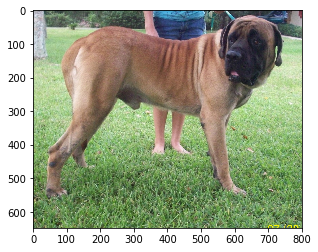

I think you could be...


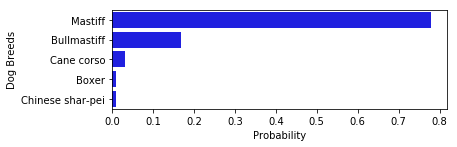

In [69]:
run_app('images/Mastiff.jpg')

Hi human


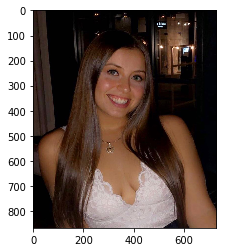

You look like a ... Afghan hound


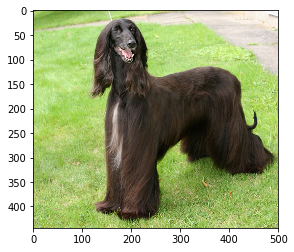

In [71]:
run_app('images/me.jpeg')

Hi human


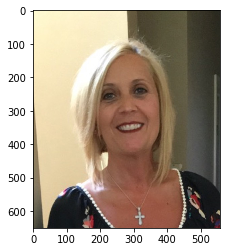

You look like a ... Havanese


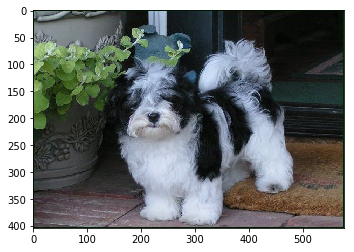

In [72]:
run_app('images/mom.jpeg')

Hi human


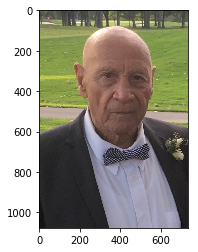

You look like a ... Norwich terrier


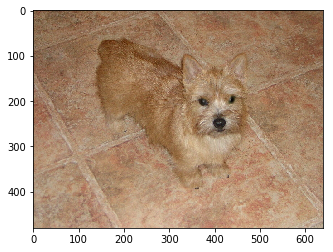

In [73]:
run_app('images/nonno.jpeg')

Hi human


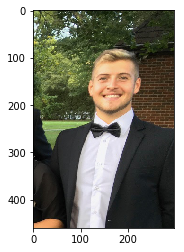

You look like a ... Bull terrier


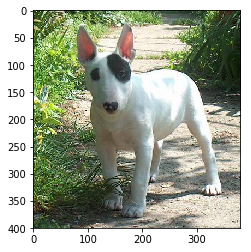

In [74]:
run_app('images/frank.jpeg')

Hi human


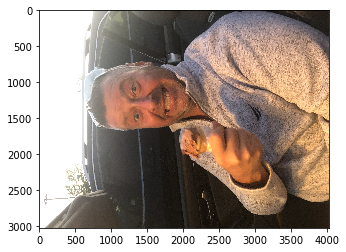

You look like a ... Dogue de bordeaux


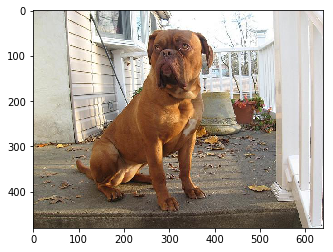

In [75]:
run_app('images/dad.jpeg')

Hi human


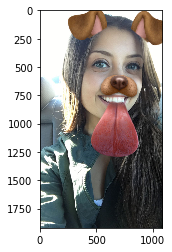

You look like a ... Afghan hound


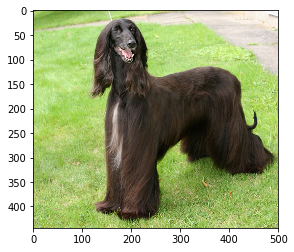

In [83]:
run_app('images/meDogFilter.jpeg')

Hi human


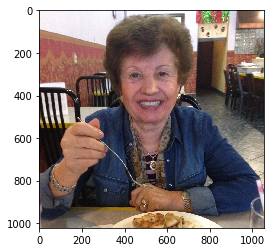

You look like a ... Glen of imaal terrier


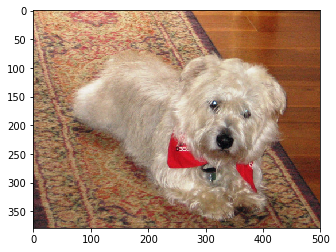

In [77]:
run_app('images/nonna.jpeg')

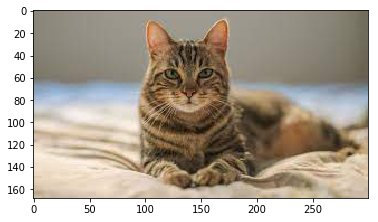

Could not detect a human or dog


In [84]:
run_app('images/cat.jpeg')

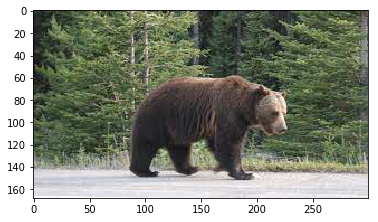

Could not detect a human or dog


In [85]:
run_app('images/bear.jpeg')

Hi puppy!


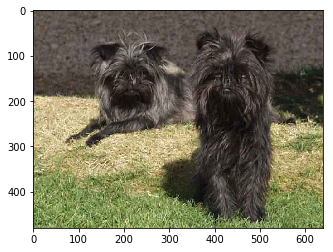

I think you could be...


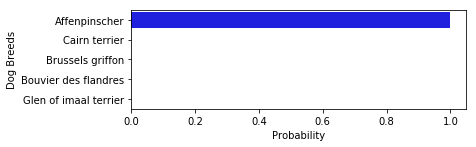

In [78]:
run_app('images/Affenpinscher_00078.jpg')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
The output was better than I expected! Starting this project, I did not think I'd be able to create a model that was 89% accurate. I also didn't think I was going to have so much fun while doing it. The results were very accurate. I tested using photos of myself and family members. Using the web app I created, I tested using my own dog as well as my cousins. The results were as expected!

The model could be improved by adding more classes as there are currently only 133 dog breeds being accounted for. The Fédération Cynologique Internationale (World Canine Organisation) currently recognizes 354 different breeds. [1] This would help in determining the breed because if an individual uploads a breed that was not account for on the web app it would predict the breed based on the breeds it has been trained on. 

Since there are not similar number of photos for each breed causing an imbalance issue, it would be beneficial to look update the dataset with the same amount of photos per breed. 

The current datasets were trained, tested, and validated with photos that were not solely of the individual dog. Some photos included people, other breeds, and other animals. Since the premise of the project is to also determine whether a human or dog is present, it could be difficult for the model to determine which is detected - a human or dog - if both are actually present in the photo. It could be better to ensure humans are not present in dog photos when training.

[1] http://www.fci.be/en/Presentation-of-our-organisation-4.html![image.png](attachment:image.png)

In [82]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    print(human_files[:3])

['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'
 '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg'
 '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg']
['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'
 '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg'
 '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg']
['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'
 '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg'
 '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg']
['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'
 '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg'
 '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg']
['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'
 '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg'
 '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg']
['/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg'
 '/data/lfw/Alex_Corretja/Alex_Corretja_0001.jpg'
 '/data/lfw/Daniele_Bergamin/Daniele_Bergamin_0001.jpg']


Hi human


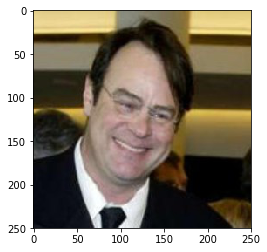

0.746808
Chihuahua
You look like a ... Chihuahua


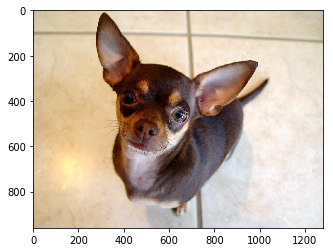

Hi human


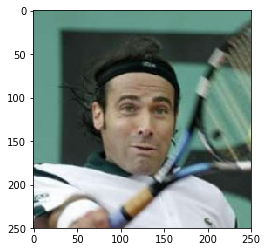

0.35243
American staffordshire terrier
You look like a ... American staffordshire terrier


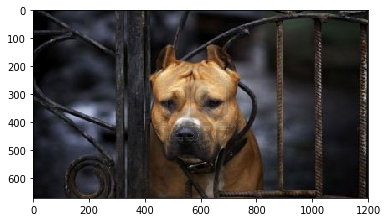

Hi human


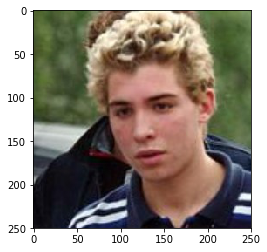

0.668148
American water spaniel
You look like a ... American water spaniel


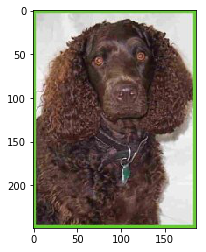

Hi human


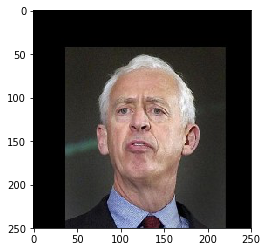

0.21583
Norfolk terrier
You look like a ... Norfolk terrier


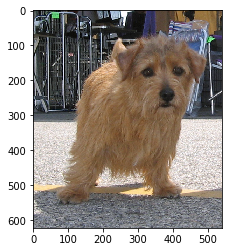

Hi human


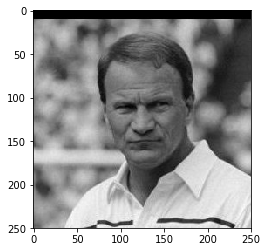

0.300519
Cane corso
You look like a ... Cane corso


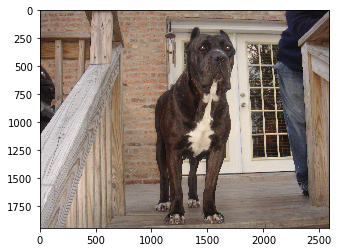

Hi puppy!


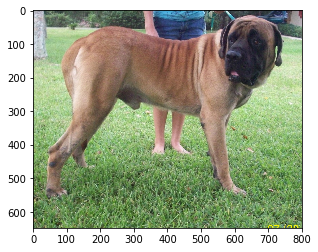

I think you could be...
0.778966
Mastiff


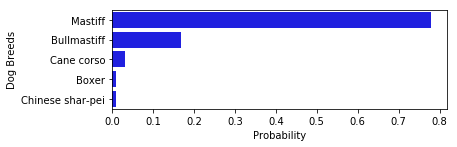

Hi puppy!


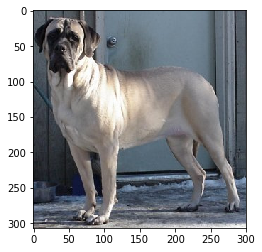

I think you could be...
0.664644
Mastiff


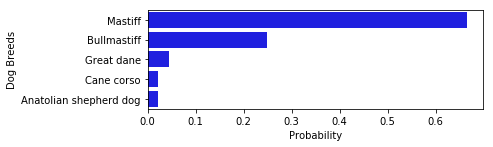

Hi puppy!


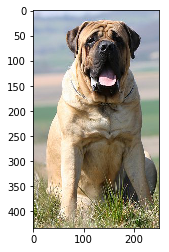

I think you could be...
0.537836
Bullmastiff


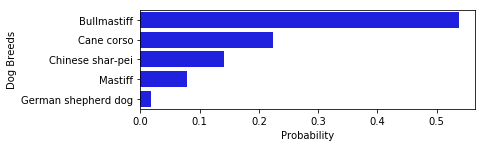

In [53]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:5], dog_files[:3])):
    run_app(file)